### Code to reproduce paper figures

The following code reproduces all figures in the manuscript. Data required for figures located in subdirectory Data_for_figures/.

In [1]:
# load modules
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Polygon
from pyproj import Proj
from scipy.stats import pearsonr
from netCDF4 import Dataset

In [2]:
### Functions for calculating NSE, R^2

def NSE_func(y_obs, y_model):
    numerator = 0
    denominator = 0
    y_obs_mean = np.mean(y_obs)
    for i in range(len(y_model)):
        num = (y_model[i] - y_obs[i])**2
        numerator += num
        denom = (y_obs[i] - y_obs_mean)**2
        denominator += denom
    nse = 1 - numerator/denominator
    return nse

def R2_func(y_obs, y_model):
    SS_res = 0
    SS_tot = 0
    y_obs_mean = np.mean(y_obs)
    for i in range(len(y_model)):
        SS_res += (y_obs[i] - y_model[i])**2
        SS_tot += (y_obs[i] - y_obs_mean)**2
    r_sq = 1 - SS_res/SS_tot
    return r_sq


#### Figure 1

In [3]:
### load basin outline data
basin_outline = pd.read_csv('Data_for_figures/Mica_basin_outline.csv', header=0)
basin_outline = np.asarray(basin_outline)
basin_outline_x = basin_outline[:,0]
basin_outline_y = basin_outline[:,1]

## convert to Shapely Polygon structure
polygon = Polygon(zip(basin_outline_x,basin_outline_y))
basin_x, basin_y = polygon.exterior.xy

In [5]:
### load elevation data
# data from NOAA ETOPO 2022 15 Arc-Second Global Relief Model
# citation: NOAA: National Centers for Environmental Information: ETOPO 2022 15 Arc-Second Global Relief Model (last access 12 Sep 2024), 2022.

# data available in certain lat/lon boxes, need 6 in total to cover desired area

elev1 = Dataset('Data_for_figures/Elevation_data/ETOPO_2022_v1_15s_N60W135_surface.nc')
lats1 = elev1.variables['lat'][:]
lons1 = elev1.variables['lon'][:]
heights1 = elev1.variables['z'][:]

elev2 = Dataset('Data_for_figures/Elevation_data/ETOPO_2022_v1_15s_N60W120_surface.nc')
lats2 = elev2.variables['lat'][:]
lons2 = elev2.variables['lon'][:]
heights2 = elev2.variables['z'][:]

elev3 = Dataset('Data_for_figures/Elevation_data/ETOPO_2022_v1_15s_N60W150_surface.nc')
lats3 = elev3.variables['lat'][:]
lons3 = elev3.variables['lon'][:]
heights3 = elev3.variables['z'][:]

elev4 = Dataset('Data_for_figures/Elevation_data/ETOPO_2022_v1_15s_N75W150_surface.nc')
lats4 = elev4.variables['lat'][:]
lons4 = elev4.variables['lon'][:]
heights4 = elev4.variables['z'][:]

elev5 = Dataset('Data_for_figures/Elevation_data/ETOPO_2022_v1_15s_N75W135_surface.nc')
lats5 = elev5.variables['lat'][:]
lons5 = elev5.variables['lon'][:]
heights5 = elev5.variables['z'][:]

elev6 = Dataset('Data_for_figures/Elevation_data/ETOPO_2022_v1_15s_N75W120_surface.nc')
lats6 = elev6.variables['lat'][:]
lons6 = elev6.variables['lon'][:]
heights6 = elev6.variables['z'][:]


## trim data to desired box

# cut file 2 to end at -110
inds_keep = np.where(lons2 <= -110)[0]
heights2_cut = heights2[:,inds_keep]
lons2_cut = lons2[inds_keep]
#print(heights2_cut.shape)

# cut file 3 to start at -138
inds_keep = np.where(lons3 >= -138)[0]
heights3_cut = heights3[:,inds_keep]
lons3_cut = lons3[inds_keep]
#print(heights3_cut.shape)

# cut file 4
inds_keep = np.where(lats4 <= 61)[0]
inds_keep2 = np.where(lons4 >= -138)[0]
heights4_cut1 = heights4[:,inds_keep2]
heights4_cut = heights4_cut1[inds_keep,:]
lons4_cut = lons4[inds_keep2]
lats4_cut = lats4[inds_keep]
#print(heights4_cut.shape)

# cut file 5
inds_keep = np.where(lats5 <= 61)[0]
heights5_cut = heights5[inds_keep,:]
lats5_cut = lats5[inds_keep]
#print(heights4_cut.shape)

# cut file 6
inds_keep = np.where(lats6 <= 61)[0]
inds_keep2 = np.where(lons6 <= -110)[0]
heights6_cut1 = heights6[:, inds_keep2]
heights6_cut = heights6_cut1[inds_keep,:]
lons6_cut = lons6[inds_keep2]
lats6_cut = lats6[inds_keep]
#print(heights4_cut.shape)

## combine all files
elevation_all = np.empty((3600+240,720+3600+2400))
elevation_all[0:240,0:720] = heights4_cut
elevation_all[0:240,720:720+3600] = heights5_cut
elevation_all[0:240,720+3600:] = heights6_cut
elevation_all[240:,0:720] = heights3_cut
elevation_all[240:,720:720+3600] = heights1
elevation_all[240:,720+3600:] = heights2_cut

lons_all = np.empty((720+3600+2400))
lons_all[0:720] = lons3_cut
lons_all[720:720+3600] = lons1
lons_all[720+3600:] = lons2_cut

lats_all = np.empty((240+3600))
lats_all[0:240] = lats4_cut
lats_all[240:] = lats3

# flip vertical axis to go from greatest lat to smallest lat
elevation_flip = np.flip(elevation_all, axis=0)
print(elevation_flip.shape)

(3840, 6720)


C:\Users\Taylor\AppData\Local\Temp\ipykernel_36344\975587175.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


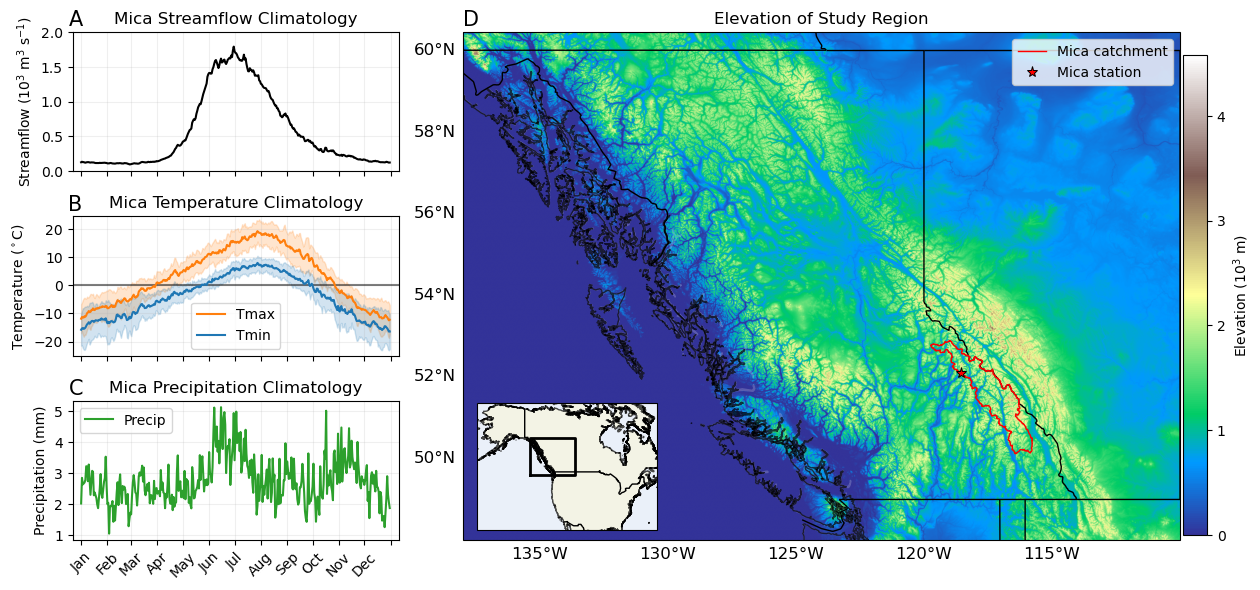

In [32]:
### plot

# cartopy features
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '10m', edgecolor='w', alpha=0.2, facecolor='none', linewidth=1)
ocean2 = cfeature.NaturalEarthFeature('physical', 'ocean', '10m', edgecolor='w', alpha=0.2, facecolor=cfeature.COLORS['water'], linewidth=1)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m', edgecolor='k', linewidth=1, facecolor='none')
coasts = cfeature.GSHHSFeature(scale='intermediate', levels=[1], facecolor='none', edgecolor='k', alpha=0.7, linewidth=1)
coasts2 = cfeature.GSHHSFeature(scale='intermediate', levels=[1], facecolor=cfeature.COLORS['land'], edgecolor='k', alpha=0.7, linewidth=1)
provinces = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', facecolor='none', edgecolor='k', linewidth=1)

# month labels and indices for climatology
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
month_inds = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]

# set up figure
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid(shape=(3,6), loc=(0,0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(shape=(3,6), loc=(1,0), colspan=2, rowspan=1)
ax3 = plt.subplot2grid(shape=(3,6), loc=(2,0), colspan=2, rowspan=1)
ax4 = plt.subplot2grid(shape=(3,6), loc=(0,2), colspan=4, rowspan=3, projection=ccrs.PlateCarree(), aspect='auto')

## A) ax1: Mica streamflow climatology
data_Mica_clim = pd.read_csv('Data_for_figures/BPA_climatology_1982_2017.csv')
data_Mica_clim = np.array(data_Mica_clim)
ax1.plot(data_Mica_clim[:,1]/1000, 'k-')
ax1.set_xticks(month_inds, [])
ax1.set_ylabel(r'Streamflow ($\mathregular{10^3}$ $\mathregular{m^3}$ $\mathregular{s^{-1}}$)')
ax1.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0], [0.0, 0.5, 1.0, 1.5, 2.0])
ax1.set_title('Mica Streamflow Climatology')
ax1.text(-15, 2.09, 'A', fontsize=15)
ax1.set_ylim(0.0, 2.0)
ax1.set_xlim(-10,375)
ax1.grid(which='major', axis='both', alpha=0.2)

## B) ax2: Mica temperature climatology
data_input_clim = pd.read_csv('Data_for_figures/Daily_climatology_Mica_1981_2018_REGRID.csv', header=0)
data_input_clim = np.array(data_input_clim)
ax2.hlines(0,-10,375, linestyle='-', color='k', alpha=0.5)
ax2.plot(data_input_clim[:,3]-273.15, '-', color='tab:orange', label='Tmax')
ax2.fill_between(np.arange(0,365,1), data_input_clim[:,3]-273.15+data_input_clim[:,4], data_input_clim[:,3]-273.15-data_input_clim[:,4],
                 color='tab:orange', alpha=0.2)
ax2.plot(data_input_clim[:,1]-273.15, '-', color='tab:blue', label='Tmin')
ax2.fill_between(np.arange(0,365,1), data_input_clim[:,1]-273.15+data_input_clim[:,2], data_input_clim[:,1]-273.15-data_input_clim[:,2],
                 color='tab:blue', alpha=0.2)
ax2.set_xticks(month_inds, [])
ax2.set_ylabel(r'Temperature ($\mathregular{^\circ}$C)')
ax2.set_title('Mica Temperature Climatology')
ax2.grid(which='major', axis='both', alpha=0.2)
ax2.text(-15, 26.6, 'B', fontsize=15)
ax2.legend()
ax2.set_xlim(-10,375)
ax2.set_ylim(-25,24.5)

## C) ax3: Mica precip climatology
ax3.plot(data_input_clim[:,7]/(10**(-3)), '-', color='tab:green', label='Precip')
#ax3.fill_between(np.arange(0,365,1), data_input_clim[:,7]/(10**(-3)), color='tab:green', alpha=0.2)
ax3.set_xticks(month_inds, month_labels, rotation=45)
ax3.set_ylabel('Precipitation (mm)')
ax3.set_title('Mica Precipitation Climatology')
ax3.grid(which='major', axis='both', alpha=0.2)
ax3.text(-15, 5.54, 'C', fontsize=15)
ax3.legend()
ax3.set_xlim(-10,375)

## D) ax4: elevation map w/ inset for study region
plt_extent = [-138,-110,45,61]
ax4.set_extent([-138, -110, 48, 60])
ax4.add_feature(ocean)
ax4.add_feature(coasts)
ax4.add_feature(borders)
ax4.add_feature(provinces)
im = ax4.imshow(elevation_flip/(10**3), aspect='auto', cmap='terrain', extent=plt_extent, vmin=0)
x, y = polygon.exterior.xy
ax4.plot(basin_x, basin_y, '-', color='r', linewidth=1, transform=ccrs.epsg(32610), label='Mica catchment')
ax4.plot(-118.57, 52.08, 'r*', markersize=8, markeredgecolor='k', markeredgewidth=0.7, label='Mica station')  # Mica
gl = ax4.gridlines(draw_labels = True, linestyle='--')
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(-150,100,5))
gl.ylocator = mticker.FixedLocator(np.arange(40,70,2))
gl.xlabel_style = {'size':12}
gl.ylabel_style = {'size':12}
gl.top_labels = False
gl.right_labels = False
ax4.legend()
ax4.set_title('Elevation of Study Region')
ax4.text(-138,60.6, 'D', fontsize=15)

cb_ax = fig.add_axes([0.99, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax, label=r'Elevation ($\mathregular{10^3}$ m)')

# add inset of N.America
ax5 = ax4.inset_axes([0.02, 0.02, 0.25, 0.25], projection=ccrs.PlateCarree(), aspect='auto')
canada_east = -60
canada_west = -170
canada_north = 60
canada_south = 30
ax5.set_extent([canada_west, canada_east, canada_south, canada_north])
ax5.add_feature(ocean2)
ax5.add_feature(coasts2)
ax5.add_feature(borders)
box_x = [-138,-138,-110,-110,-138]
box_y = [48,60,60,48,48]
ax5.plot(box_x,box_y, 'k', transform = ccrs.PlateCarree(), linewidth = 2)

plt.tight_layout()
plt.show()
#plt.savefig('Fig01.pdf', bbox_inches='tight')

#### Figure 2

In [8]:
### load data

# daily - 365 days
filename1 = 'Data_for_figures/Singlebasin_LSTM1_L1O_run32_output_unnorm.csv'
daily_run32 = pd.read_csv(filename1, header=0)
daily_run32 = np.array(daily_run32)
daily_run32_NSE = NSE_func(daily_run32[:,0], daily_run32[:,1])

# monthly - 12-month
filename2 = 'Data_for_figures/Singlebasin_LSTM6_L1O_run32_output_unnorm.csv'
monthly12_run32 = pd.read_csv(filename2, header=0)
monthly12_run32 = np.array(monthly12_run32)
monthly12_run32_NSE = NSE_func(monthly12_run32[:,0], monthly12_run32[:,1])

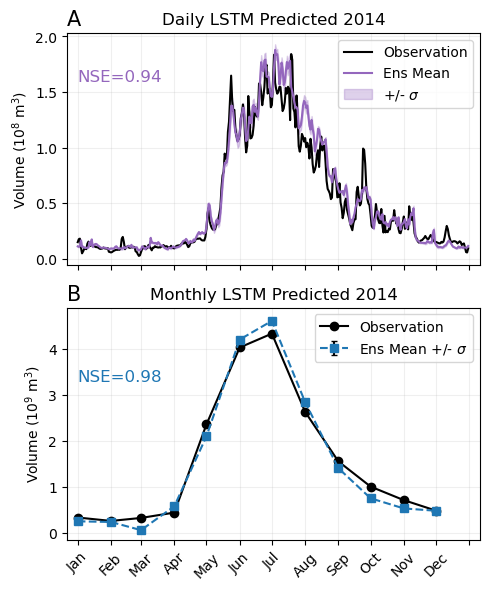

In [33]:
### plot

# month labels and indices
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
month_inds = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]

# convert daily (m^3/s) to volume (m^3)
daily_run32_vol = daily_run32*86400

# plot
fig = plt.figure(figsize=(5,6))
# daily
plt.subplot(211)
plt.plot(np.arange(0,365,1), daily_run32_vol[:,0]/(10**8), 'k-', label='Observation')
plt.plot(np.arange(0,365,1), daily_run32_vol[:,1]/(10**8), '-', color='tab:purple', label='Ens Mean')
plt.fill_between(np.arange(0,365,1), (daily_run32_vol[:,1]+daily_run32_vol[:,2])/(10**8),
                 (daily_run32_vol[:,1]-daily_run32_vol[:,2])/(10**8), color='tab:purple', alpha=0.3, label=r'+/- $\sigma$')
plt.text(0, 1.6, 'NSE='+str(round(daily_run32_NSE,2)), color='tab:purple', fontsize=12)
plt.xticks(month_inds, [])
plt.ylabel(r'Volume ($\mathregular{10^8}$ $\mathregular{m^3}$)')
plt.title('Daily LSTM Predicted 2014')
plt.legend()
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-10, 2.1, 'A', fontsize=15)
plt.xlim(-10, 375)
plt.ylim(-0.06,2.03)
# monthly
plt.subplot(212)
plt.plot(month_inds[:-1], monthly12_run32[:,0]/(10**9), 'ko-', label='Observation')
plt.errorbar(month_inds[:-1], monthly12_run32[:,1]/(10**9), yerr=monthly12_run32[:,2]/(10**9), fmt='s--',
             color='tab:blue', ecolor='black', capsize=2, label=r'Ens Mean +/- $\sigma$')
plt.text(0, 3.3, 'NSE='+str(round(monthly12_run32_NSE,2)), color='tab:blue', fontsize=12)
plt.xticks(month_inds, month_labels, rotation=45)
plt.ylabel(r'Volume ($\mathregular{10^9}$ $\mathregular{m^3}$)')
plt.title('Monthly LSTM Predicted 2014')
plt.legend()
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-10,5.05, 'B', fontsize=15)
plt.xlim(-10, 375)
plt.ylim(-0.16,4.9)
plt.tight_layout()
plt.show()
#plt.savefig('Fig02.pdf')

#### Figure 3

In [11]:
### load data

# daily - 365 days
filename3 = 'Data_for_figures/Singlebasin_LSTM1_L1O_Set1_LSTM_volumes.csv'
daily_vols = pd.read_csv(filename3, header=0)
daily_vols = np.array(daily_vols)
daily_vols_R2 = R2_func(daily_vols[:,1], daily_vols[:,2])
daily_vols_r, daily_vols_p = pearsonr(daily_vols[:,1], daily_vols[:,2])

# monthly - 12-month
filename4 = 'Data_for_figures/Singlebasin_LSTM6_L1O_Set1_LSTM_volumes.csv'
monthly12_vols = pd.read_csv(filename4, header=0)
monthly12_vols = np.array(monthly12_vols)
monthly12_vols_R2 = R2_func(monthly12_vols[:,1], monthly12_vols[:,2])
monthly12_vols_r, monthly12_vols_p = pearsonr(monthly12_vols[:,1], monthly12_vols[:,2])

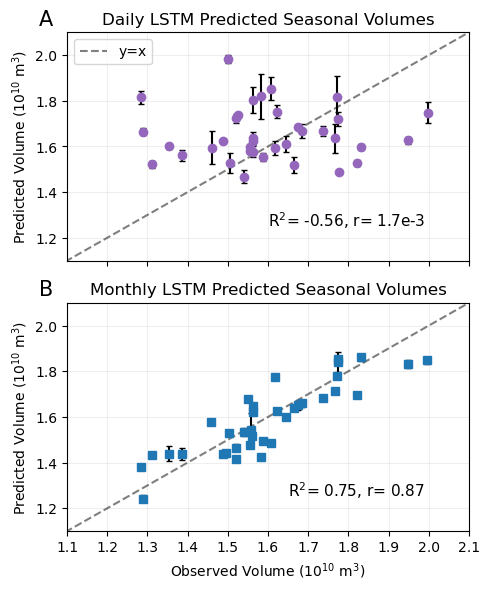

In [34]:
### plot

# create y=x line to plot
y_equals_x = np.arange(1.0, 2.4, 0.1)

# plot
fig = plt.figure(figsize=(5,6))
# daily
plt.subplot(211)
plt.plot(y_equals_x, y_equals_x, 'k--', alpha=0.5, label='y=x')
plt.errorbar(daily_vols[:,1]/(10**10), daily_vols[:,2]/(10**10), yerr=daily_vols[:,3]/(10**10), fmt='o', color='tab:purple',
             ecolor='black', capsize=2)
plt.text(1.6, 1.25, r'$ \mathdefault{R}^2$= '+str(round(daily_vols_R2,2))+', r= 1.7e-3', fontsize=11)
plt.xticks([1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1], [])
plt.ylabel(r'Predicted Volume ($\mathdefault{10^{10}}$ $\mathdefault{m^3}$)')
plt.title('Daily LSTM Predicted Seasonal Volumes')
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(1.03, 2.13, 'A', fontsize=15)
plt.xlim(1.1, 2.1)
plt.ylim(1.1, 2.1)
plt.legend()
# monthly
plt.subplot(212)
plt.plot(y_equals_x, y_equals_x, 'k--', alpha=0.5, label='y=x')
plt.errorbar(monthly12_vols[:,1]/(10**10), monthly12_vols[:,2]/(10**10), yerr=monthly12_vols[:,3]/(10**10), fmt='s', color='tab:blue',
             ecolor='black', capsize=2)
plt.text(1.65, 1.25, r'$\mathdefault{R}^2$= '+str(round(monthly12_vols_R2,2))+', r= '+str(round(monthly12_vols_r,2)), fontsize=11)
plt.xlabel(r'Observed Volume ($\mathregular{10^{10}}$ $\mathregular{m^3}$)')
plt.xticks([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1], [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1])
plt.ylabel(r'Predicted Volume ($\mathdefault{10^{10}}$ $\mathdefault{m^3}$)')
plt.title('Monthly LSTM Predicted Seasonal Volumes')
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(1.03, 2.13, 'B', fontsize=15)
plt.xlim(1.1, 2.1)
plt.ylim(1.1, 2.1)
plt.tight_layout()
plt.show()
#plt.savefig('Fig03.pdf')

#### Figure 4

In [18]:
### load data

## load Kratzert et al. (2019) output data
# this data is from the public repository of Kratzert et al. (2019)
# citation:  Kratzert, F., Klotz, D., Shalev, G., Klambauer, G., Hochreiter, S., and Nearing, G.: Towards learning universal, regional, and local 
#            hydrological behaviors via machine learning applied to large-sample datasets, Hydrology and Earth System Sciences, 23, 5089–5110,
#            https://doi.org/10.5194/hess-23-5089-2019, 2019.
# Only kept stations with NSE>0
Kratzert_data = pd.read_csv('Data_for_figures/Kratzert_stations_data.csv', header=None)
Kratzert_data = np.array(Kratzert_data)
K_NSE = Kratzert_data[0,1:]
K_R2 = Kratzert_data[1,1:]
K_r2 = Kratzert_data[2,1:]
K_r = np.sqrt(K_r2.astype('float'))
K_vol = Kratzert_data[3,1:]
K_annualvol = Kratzert_data[4,1:]
K_NSE_mean = np.mean(K_NSE)
K_NSE_std = np.std(K_NSE)
K_R2_mean = np.mean(K_R2)
K_R2_std = np.std(K_R2)
K_r2_mean = np.mean(K_r2)
K_r2_std = np.std(K_r2)
K_r_mean = np.mean(K_r)
K_r_std = np.std(K_r)
K_vol_mean = np.mean(K_vol)
K_vol_std = np.std(K_vol)
K_annualvol_mean = np.mean(K_annualvol)
K_annualvol_std = np.std(K_annualvol)

# load Anderson & Radic (2022) output data
# this data is output generated by the published models of Anderson and Radic (2022)
# citation: Anderson, S. and Radic, V.: Evaluation and interpretation of convolutional long short-term memory networks for regional 
#           hydrological modelling, Hydrology and Earth System Sciences, 26, 795–825, https://doi.org/10.5194/hess-26-795-2022, 2022.
# Only kept stations with NSE > 0
Anderson_data = pd.read_csv('Data_for_figures/AndersonRadic_stations_data.csv', header=None)
Anderson_data = np.array(Anderson_data)
AR_NSE = Anderson_data[0,1:]
AR_R2 = Anderson_data[1,1:]
AR_r2 = Anderson_data[2,1:]
AR_r = np.sqrt(AR_r2.astype('float'))
AR_vol = Anderson_data[3,1:]
AR_annualvol = Anderson_data[4,1:]
AR_NSE_mean = np.mean(AR_NSE)
AR_NSE_std = np.std(AR_NSE)
AR_R2_mean = np.mean(AR_R2)
AR_R2_std = np.std(AR_R2)
AR_r2_mean = np.mean(AR_r2)
AR_r2_std = np.std(AR_r2)
AR_r_mean = np.mean(AR_r)
AR_r_std = np.std(AR_r)
AR_vol_mean = np.mean(AR_vol)
AR_vol_std = np.std(AR_vol)
AR_annualvol_mean = np.mean(AR_annualvol)
AR_annualvol_std = np.std(AR_annualvol)

# my monthly LSTM model (12-month)
T3_data = pd.read_csv('Data_for_figures/Singlebasin_LSTM6_L1O_Set1_NSE.csv', header=0)
T3_data = np.array(T3_data)
T3_NSE = T3_data[:,1]
T3_NSE_mean = np.mean(T3_NSE)
T3_NSE_std = np.std(T3_NSE)
T3_R2 = 0.74856436
T3_r2 = 0.75476353
T3_r = 0.868771274

# my daily LSTM model
T1_data = pd.read_csv('Data_for_figures/Singlebasin_LSTM1_L1O_Set1_NSE.csv', header=0)
T1_data = np.array(T1_data)
T1_NSE = T1_data[:,1]
T1_NSE_mean = np.mean(T1_NSE)
T1_NSE_std = np.std(T1_NSE)
T1_R2 = -0.5645423617023155
T1_r2 = 2.8743182071252828e-06
T1_r = 0.0016953814341105
Mica_vol_mean = 15999854439.11424
Mica_vol_std = 1670098423.1828501


In [19]:
### keep stations with R^2 > -1.0 only

# find indices where R2 > -1.0
K_R2_neg1_inds = np.where(K_R2 > -1.0)[0]
K_R2_neg1_N = len(K_R2_neg1_inds)
AR_R2_neg1_inds = np.where(AR_R2 > -1.0)[0]
AR_R2_neg1_N = len(AR_R2_neg1_inds)

# select stations that satisfy condition
K_R2_neg1 = K_R2[K_R2_neg1_inds]
K_r2_neg1 = K_r2[K_R2_neg1_inds]
K_r_neg1 = K_r[K_R2_neg1_inds]
K_NSE_neg1 = K_NSE[K_R2_neg1_inds]
AR_R2_neg1 = AR_R2[AR_R2_neg1_inds]
AR_r2_neg1 = AR_r2[AR_R2_neg1_inds]
AR_r_neg1 = AR_r[AR_R2_neg1_inds]
AR_NSE_neg1 = AR_NSE[AR_R2_neg1_inds]

print("Number of stations:")
print("Kratzert et al, N = ", K_R2_neg1_N)
print("Anderson & Radic, N = ", AR_R2_neg1_N)

Number of stations:
Kratzert et al, N =  472
Anderson & Radic, N =  43


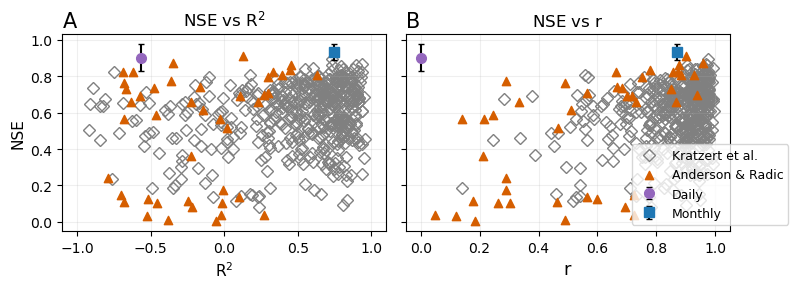

In [35]:
### plot

fig = plt.figure(figsize=(8,3))
# NSE vs R^2
plt.subplot(121)
plt.plot(K_R2_neg1, K_NSE_neg1, 'D', markeredgecolor='gray', markerfacecolor='none', zorder=1, label='Kratzert'.format(K_R2_neg1_N))
plt.scatter(AR_R2_neg1, AR_NSE_neg1, marker='^', color='#D55E00', zorder=2, label='Anderson'.format(AR_R2_neg1_N))
plt.errorbar(T1_R2, T1_NSE_mean, yerr=T1_NSE_std, fmt='o', color='tab:purple', ecolor='black', capsize=2, 
             markersize=7, label='Daily'.format(1))
plt.errorbar(T3_R2, T3_NSE_mean, yerr=T3_NSE_std, fmt='s', color='tab:blue', ecolor='black', capsize=2, 
             markersize=7, label='Monthly'.format(1))
plt.ylabel("NSE", fontsize=11)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel(r'$\mathdefault{R}^2$', fontsize=11)
plt.title(r'NSE vs $\mathdefault{R}^2$')
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-1.10, 1.07, 'A', fontsize=15)
plt.xlim(-1.10, 1.10)
plt.ylim(-0.05, 1.03)
# NSE vs r
plt.subplot(122)
plt.plot(K_r_neg1, K_NSE_neg1, 'D', markeredgecolor='gray', markerfacecolor='none', zorder=1, label='Kratzert et al.')
plt.scatter(AR_r_neg1, AR_NSE_neg1, marker='^', color='#D55E00', zorder=2, label=r'Anderson & Radic')
plt.errorbar(T1_r, T1_NSE_mean, yerr=T1_NSE_std, fmt='o', color='tab:purple', ecolor='black', capsize=2, 
             markersize=7, label='Daily'.format(1))
plt.errorbar(T3_r, T3_NSE_mean, yerr=T3_NSE_std, fmt='s', color='tab:blue', ecolor='black', capsize=2, 
             markersize=7, label='Monthly'.format(1))
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], [])
plt.xlabel(r'$\mathdefault{r}$', fontsize=13)
plt.title(r'NSE vs $\mathdefault{r}$')
plt.legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.2,0))
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-0.05, 1.07, 'B', fontsize=15)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.03)
plt.tight_layout()
plt.show()
#plt.savefig('Fig04.pdf')

#### Figure 6

In [21]:
### load data

# r^2
filename5 = 'Data_for_figures/Singlebasin_LSTM6_L1O_ERAClimCombo_r2_allsets(1).csv'
r2_allsets_wlabels = pd.read_csv(filename5, header=0)
r2_allsets_wlabels = np.array(r2_allsets_wlabels)
r2_allsets = np.array(r2_allsets_wlabels[:,1:], dtype=float)
r_allsets = np.sqrt(r2_allsets[:,1:])

# R^2
filename6 = 'Data_for_figures/Singlebasin_LSTM6_L1O_ERAClimCombo_R2_allsets.csv'
R2_allsets_wlabels = pd.read_csv(filename6, header=0)
R2_allsets_wlabels = np.array(R2_allsets_wlabels)
R2_allsets = np.array(R2_allsets_wlabels[:,1:], dtype=float)

# average over all sets
R2_allsets_avg = np.mean(R2_allsets[:,1:], axis=1)
R2_allsets_std = np.std(R2_allsets[:,1:], axis=1)
r2_allsets_avg = np.mean(r2_allsets[:,1:], axis=1)
r2_allsets_std = np.std(r2_allsets[:,1:], axis=1)
r_allsets_avg = np.mean(r_allsets[:,:], axis=1)
r_allsets_std = np.std(r_allsets[:,:], axis=1)

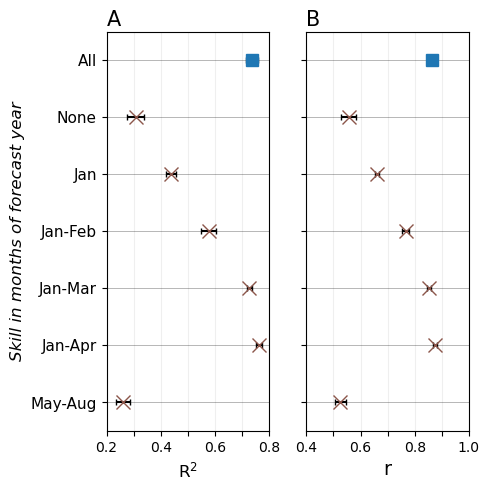

In [36]:
### plot

fig = plt.figure(figsize=(5,5))
# plot R^2
plt.subplot(121)
plt.errorbar(R2_allsets_avg[0], 9, xerr=R2_allsets_std[0], fmt='s', markersize=8, color='tab:blue',
             ecolor='black', capsize=2)  # ERA5
plt.errorbar(R2_allsets_avg[1], 8, xerr=R2_allsets_std[1], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2)  # wclim0
plt.errorbar(R2_allsets_avg[3], 7, xerr=R2_allsets_std[3], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2) # woclimJ
plt.errorbar(R2_allsets_avg[4], 6, xerr=R2_allsets_std[4], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2) # woclimJF
plt.errorbar(R2_allsets_avg[5], 5, xerr=R2_allsets_std[5], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2) # woclimJFM
plt.errorbar(R2_allsets_avg[6], 4, xerr=R2_allsets_std[6], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2) # woclimJFMA
plt.errorbar(R2_allsets_avg[8], 3, xerr=R2_allsets_std[8], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2) # wclimJFMA
# horizontal lines (to keep vertical grid lines lighter in colour):
plt.plot(np.arange(0.2,0.9,0.1), np.full((7,),9), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.2,0.9,0.1), np.full((7,),8), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.2,0.9,0.1), np.full((7,),7), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.2,0.9,0.1), np.full((7,),6), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.2,0.9,0.1), np.full((7,),5), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.2,0.9,0.1), np.full((7,),4), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.2,0.9,0.1), np.full((7,),3), 'k-', linewidth=0.5, alpha=0.4)
plt.yticks([9,8,7,6,5,4,3], ['All','None','Jan','Jan-Feb','Jan-Mar', 'Jan-Apr', 'May-Aug'], fontsize=11)
plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], [0.2, '', 0.4, '', 0.6, '', 0.8])
plt.ylabel('Skill in months of forecast year', fontsize=12, fontstyle='italic')
plt.xlabel(r'$\mathdefault{R}^2$', fontsize=12)
plt.grid(which='both', axis='x', alpha=0.2)
plt.text(0.2, 9.6, 'A', fontsize=15)
plt.ylim(2.5,9.5)
plt.xlim(0.2,0.8)
# plot r^2
plt.subplot(122)
plt.errorbar(r_allsets_avg[0], 9, xerr=r_allsets_std[0], fmt='s', markersize=8, color='tab:blue',
             ecolor='black', capsize=2)
plt.errorbar(r_allsets_avg[1], 8, xerr=r_allsets_std[1], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2)
plt.errorbar(r_allsets_avg[3], 7, xerr=r_allsets_std[6], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2)
plt.errorbar(r_allsets_avg[4], 6, xerr=r_allsets_std[4], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2)
plt.errorbar(r_allsets_avg[5], 5, xerr=r_allsets_std[5], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2)
plt.errorbar(r_allsets_avg[6], 4, xerr=r_allsets_std[6], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2)
plt.errorbar(r_allsets_avg[8], 3, xerr=r_allsets_std[8], fmt='x', markersize=10, color='tab:brown',
             ecolor='black', capsize=2)
# horizontal lines (to keep vertical grid lines lighter in colour):
plt.plot(np.arange(0.4,1.1,0.1), np.full((7,),9), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.4,1.1,0.1), np.full((7,),8), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.4,1.1,0.1), np.full((7,),7), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.4,1.1,0.1), np.full((7,),6), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.4,1.1,0.1), np.full((7,),5), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.4,1.1,0.1), np.full((7,),4), 'k-', linewidth=0.5, alpha=0.4)
plt.plot(np.arange(0.4,1.1,0.1), np.full((7,),3), 'k-', linewidth=0.5, alpha=0.4)
plt.yticks([9,8,7,6,5,4,3],[])
plt.xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [0.4, '', 0.6, '', 0.8, '', 1.0])
plt.xlabel(r'$\mathdefault{r}$', fontsize=14)
plt.grid(which='both', axis='x', alpha=0.2)
plt.text(0.4, 9.6, 'B', fontsize=15)
plt.ylim(2.5,9.5)
plt.xlim(0.4,1.0)

plt.tight_layout()
plt.show()
#plt.savefig('Fig06.pdf')

#### Figure 7

In [ ]:
### load data
# data saved in Data_setup.ipynb, must run this first
# then data located in /../Hybrid_LSTM/Data/

# SEAS5 forecast data
input_forecast = pd.read_csv('/../Hybrid_LSTM/Data/SEAS5_monthly_input_Mica_1981_2017.csv', header=0)
input_forecast = np.array(input_forecast)

# ERA5 regridded
# Tmin, Tmax, Precip
input_ERA5 = pd.read_csv('/../Hybrid_LSTM/Data/Monthly_input_Mica_1981_2017_REGRID.csv', header=0)
input_ERA5 = np.array(input_ERA5)

## cut ERA5 to SEAS5 shape (first 6 months of year only)
SEAS5_input_Mica = input_forecast[:,1:]
ERA5_input_Mica = np.empty_like(SEAS5_input_Mica)
years_SEAS5 = np.arange(1981,2018,1)
for y, year in enumerate(years_SEAS5):
    start_yearind = np.where(input_ERA5[:,0] == '01-'+str(year))[0][0]
    ERA5_input_Mica[y*6:(y+1)*6,:] = input_ERA5[start_yearind:start_yearind+6,1:]

# separate months for each year
SEAS5_input_Mica_3D = np.zeros((len(years_SEAS5),6,3))
ERA5_input_Mica_3D = np.zeros((len(years_SEAS5),6,3))
for y in range(len(years_SEAS5)):
    SEAS5_input_Mica_3D[y,:,:] = SEAS5_input_Mica[y*6:(y+1)*6,:]
    ERA5_input_Mica_3D[y,:,:] = ERA5_input_Mica[y*6:(y+1)*6,:]

NameError: name 'ERA5_input_Mica_3D' is not defined

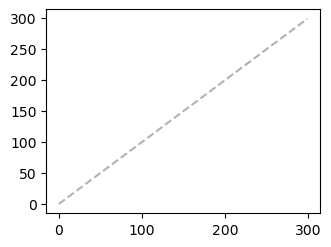

In [37]:
### plot for paper

titles = ['Lead 1 Month', 'Lead 2 Months', 'Lead 3 Months']
legends = ['Tmin', 'Tmax', 'Precip']
y_equals_x = np.arange(0, 300, 1)
min_lims = np.array([[248, 252, 258], [256, 258, 264], [0.01, 0.0, 0.02]])
max_lims = np.array([[266, 268, 270], [270, 274, 278], [0.14, 0.12, 0.14]])
colors=['tab:blue', 'tab:orange', 'tab:green']

xticks = [[250, 254, 258, 262, 266], [252, 256, 260, 264, 268], [258, 262, 266, 270],
         [256, 260, 264, 268], [258, 262, 266, 270, 274], [264, 268, 272, 276], [0.02, 0.06, 0.10, 0.14], [0.0, 0.04, 0.08, 0.12], 
         [0.02, 0.06, 0.10, 0.14]]
yticks = [[248, 252, 256, 260, 264], [254, 258, 262, 266], [260, 264, 268], [258, 262, 266, 270], [260, 264, 268, 272], [266, 270, 274, 278],
         [0.02, 0.06, 0.10, 0.14], [0.02, 0.06, 0.10], [0.04, 0.08, 0.12]]

text_x = [254, 253.5, 259, 260.7, 259.5, 265.5, 0.055, 0.013, 0.033]
text_y = [263, 265, 267.9, 267.5, 271.2, 275.6, 0.12, 0.10, 0.12]

sublabel = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
sublabel_x = [248, 252, 258, 256, 258, 264, 0.01, 0.0, 0.02]
sublabel_y = [266.6, 268.55, 270.45, 270.5, 274.5, 278.5, 0.145, 0.124, 0.144]

fig = plt.figure(figsize=(12,9))
n = 0
# loop through variables
for vv in range(3):
    # loop through 3 months
    for i in range(3):
        n += 1
        plt.subplot(3,3,n)
        plt.plot(y_equals_x, y_equals_x, 'k--', alpha=0.3, label='y=x')
        plt.plot(ERA5_input_Mica_3D[:,i,vv], SEAS5_input_Mica_3D[:,i,vv], 'o', color=colors[vv], label=legends[vv])
        plt.title(titles[i])
        plt.text(sublabel_x[n-1], sublabel_y[n-1], sublabel[n-1], fontsize=15)
        plt.xlim(min_lims[vv,i], max_lims[vv,i])
        plt.ylim(min_lims[vv,i], max_lims[vv,i])
        plt.xticks(xticks[n-1], xticks[n-1])
        plt.yticks(yticks[n-1], yticks[n-1])
        if n == 1 or n == 4:
            plt.ylabel('SEAS5 Temperature (K)')
            plt.legend(loc='upper left')
        if n == 1 or n == 2 or n == 3:
            plt.xlabel('ERA5 Temperature (K)')
        if n == 4 or n == 5 or n == 6:
            plt.xlabel('ERA5 Temperature (K)')
        if n == 7 or n == 8 or n == 9:
            plt.xlabel('ERA5 Precipitation (m)')
        if n == 7:
            plt.ylabel('SEAS5 Precipitation (m)')
            plt.legend(loc='upper left')
        # add r^2
        r_coeff, p_val = pearsonr(ERA5_input_Mica_3D[:,i,vv], SEAS5_input_Mica_3D[:,i,vv])
        if n == 8 or n == 9:
            plt.text(text_x[n-1], text_y[n-1], r'$\mathdefault{r}$='+str(round(r_coeff, 2))+', p='+str(round(p_val,2)), fontsize=10)
        else:
            plt.text(text_x[n-1], text_y[n-1], r'$\mathdefault{r}$='+str(round(r_coeff, 2))+', p<0.05', fontsize=10)
plt.tight_layout()
#plt.show()
plt.savefig('Fig07.pdf')

#### Figure 9

In [24]:
### load data

# volumes - 12-month
filename7 = 'Data_for_figures/Singlebasin_LSTM6_L1O_Set1_hybrid_volumes.csv'
hybrid12_vols = pd.read_csv(filename7, header=0)
hybrid12_vols = np.array(hybrid12_vols)
hybrid12_vols_R2 = R2_func(hybrid12_vols[:,1], hybrid12_vols[:,2])
hybrid12_vols_r, hybrid12_vols_p = pearsonr(hybrid12_vols[:,1], hybrid12_vols[:,2])

# streamflow - 12-month
filename8 = 'Data_for_figures/Singlebasin_LSTM6_L1O_run32_hybrid_output_unnorm.csv'
hybrid12_run32 = pd.read_csv(filename8, header=0)
hybrid12_run32 = np.array(hybrid12_run32)
hybrid12_run32_NSE = NSE_func(hybrid12_run32[:,0], hybrid12_run32[:,1])

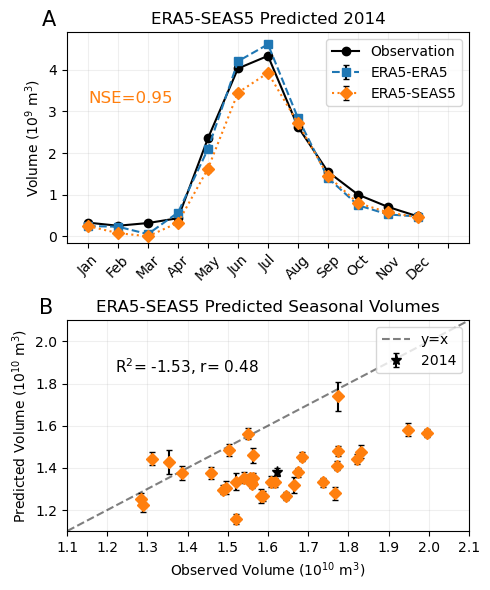

In [38]:
### plot

# month x-axis labels
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']

# plot
fig = plt.figure(figsize=(5,6))
# plot monthly volumes
plt.subplot(211)
plt.plot(hybrid12_run32[:,0]/(10**9), 'ko-', label='Observation')
plt.errorbar(np.arange(0,12,1), monthly12_run32[:,1]/(10**9), yerr=monthly12_run32[:,2]/(10**9), fmt='s--',
             color='tab:blue', ecolor='black', capsize=2, label='ERA5-ERA5')
plt.errorbar(np.arange(0,12,1), hybrid12_run32[:,1]/(10**9), yerr=hybrid12_run32[:,2]/(10**9), fmt='D:',
             color='tab:orange', ecolor='black', capsize=2, label='ERA5-SEAS5')
plt.text(0, 3.2, 'NSE='+str(round(hybrid12_run32_NSE,2)), color='tab:orange', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], month_labels, rotation=45)
plt.ylabel(r'Volume ($\mathdefault{10^9}$ $\mathdefault{m^3}$)')
plt.title('ERA5-SEAS5 Predicted 2014')
plt.legend(loc='upper right')
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-1.55,5.05, 'A', fontsize=15)
plt.xlim(-0.7,12.7)
plt.ylim(-0.16,4.9)
# plot seasonal volumes
plt.subplot(212)
plt.plot(y_equals_x, y_equals_x, 'k--', alpha=0.5, label='y=x')
plt.errorbar(hybrid12_vols[:32,1]/(10**10), hybrid12_vols[:32,2]/(10**10), yerr=hybrid12_vols[:32,3]/(10**10), fmt='D', color='tab:orange',
             ecolor='black', capsize=2)
plt.errorbar(hybrid12_vols[33:,1]/(10**10), hybrid12_vols[33:,2]/(10**10), yerr=hybrid12_vols[33:,3]/(10**10), fmt='D', color='tab:orange',
             ecolor='black', capsize=2)
plt.errorbar(hybrid12_vols[32,1]/(10**10), hybrid12_vols[32,2]/(10**10), yerr=hybrid12_vols[32,3]/(10**10), fmt='*', color='black',
             ecolor='black', capsize=2, markersize=8, label='2014')
plt.text(1.22, 1.85, r'$\mathdefault{R}^2$= '+str(round(hybrid12_vols_R2,2))+', r= '+str(round(hybrid12_vols_r,2)), fontsize=11)
plt.xlabel(r'Observed Volume ($\mathregular{10^{10}}$ $\mathregular{m^3}$)')
plt.xticks([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1], [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1])
plt.ylabel(r'Predicted Volume ($\mathdefault{10^{10}}$ $\mathdefault{m^3}$)')
plt.title('ERA5-SEAS5 Predicted Seasonal Volumes')
plt.text(1.03, 2.13, 'B', fontsize=15)
plt.xlim(1.1, 2.1)
plt.ylim(1.1, 2.1)
plt.legend(loc='upper right')
plt.grid(which='major', axis='both', alpha=0.2)
plt.tight_layout()
plt.show()
#plt.savefig('Fig09.pdf')

#### Figure 10

In [26]:
### load data

# volumes - 12-month
filename9 = 'Data_for_figures/Singlebasin_LSTM6_L1O_Set1_hybridlinshift_volumes.csv'
hybridLS12_vols = pd.read_csv(filename9, header=0)
hybridLS12_vols = np.array(hybridLS12_vols)
hybridLS12_vols_R2 = R2_func(hybridLS12_vols[:,1], hybridLS12_vols[:,2])
hybridLS12_vols_r, hybridLS12_vols_p = pearsonr(hybridLS12_vols[:,1], hybridLS12_vols[:,2])

# streamflow - 12-month
filename10 = 'Data_for_figures/Singlebasin_LSTM6_L1O_run32_hybridlinshift_output_unnorm.csv'
hybridLS12_run32 = pd.read_csv(filename10, header=0)
hybridLS12_run32 = np.array(hybridLS12_run32)
hybridLS12_run32_NSE = NSE_func(hybridLS12_run32[:,0], hybridLS12_run32[:,1])

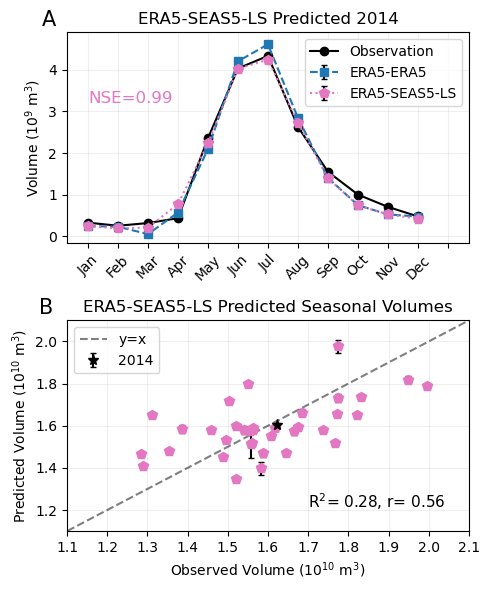

In [39]:
### plot

# month x-axis labels and indices
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
month_inds = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]

# plot
fig = plt.figure(figsize=(5,6))
# plot monthly volumes
plt.subplot(211)
plt.plot(hybridLS12_run32[:,0]/(10**9), 'ko-', label='Observation')
plt.errorbar(np.arange(0,12,1), monthly12_run32[:,1]/(10**9), yerr=monthly12_run32[:,2]/(10**9), fmt='s--',
             color='tab:blue', ecolor='black', capsize=2, label='ERA5-ERA5')
plt.errorbar(np.arange(0,12,1), hybridLS12_run32[:,1]/(10**9), yerr=hybridLS12_run32[:,2]/(10**9), fmt='p:',
             color='tab:pink', ecolor='black', capsize=2, markersize=7, label='ERA5-SEAS5-LS')
plt.text(0, 3.2, 'NSE='+str(round(hybridLS12_run32_NSE,2)), color='tab:pink', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], month_labels, rotation=45)
plt.ylabel(r'Volume ($\mathdefault{10^9}$ $\mathdefault{m^3}$)')
plt.title('ERA5-SEAS5-LS Predicted 2014')
plt.legend(loc='upper right')
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-1.55,5.05, 'A', fontsize=15)
plt.xlim(-0.7,12.7)
plt.ylim(-0.16,4.9)
# plot seasonal volumes
plt.subplot(212)
plt.plot(y_equals_x, y_equals_x, 'k--', alpha=0.5, label='y=x')
plt.errorbar(hybridLS12_vols[:32,1]/(10**10), hybridLS12_vols[:32,2]/(10**10), yerr=hybridLS12_vols[:32,3]/(10**10), fmt='p', color='tab:pink',
             ecolor='black', capsize=2, markersize=7)
plt.errorbar(hybridLS12_vols[33:,1]/(10**10), hybridLS12_vols[33:,2]/(10**10), yerr=hybridLS12_vols[33:,3]/(10**10), fmt='p', color='tab:pink',
             ecolor='black', capsize=2, markersize=7)
plt.errorbar(hybridLS12_vols[32,1]/(10**10), hybridLS12_vols[32,2]/(10**10), yerr=hybridLS12_vols[32,3]/(10**10), fmt='*', color='black',
             ecolor='black', capsize=2, markersize=8, label='2014')
plt.text(1.7, 1.21, r'$\mathdefault{R}^2$= '+str(round(hybridLS12_vols_R2,2))+', r= '+str(round(hybridLS12_vols_r,2)), fontsize=11)
plt.xlabel(r'Observed Volume ($\mathregular{10^{10}}$ $\mathregular{m^3}$)')
plt.xticks([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1], [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1])
plt.ylabel(r'Predicted Volume ($\mathdefault{10^{10}}$ $\mathdefault{m^3}$)')
plt.title('ERA5-SEAS5-LS Predicted Seasonal Volumes')
plt.text(1.03, 2.13, 'B', fontsize=15)
plt.xlim(1.1, 2.1)
plt.ylim(1.1, 2.1)
plt.legend(loc='upper left')
plt.grid(which='major', axis='both', alpha=0.2)
plt.tight_layout()
plt.show()
#plt.savefig('Fig10.pdf')

#### Figure 11

In [28]:
### load data

# volumes - 12-month
filename11 = 'Data_for_figures/Singlebasin_LSTM6_L1O_Set1_hybridQQ_volumes.csv'
hybridQQ12_vols = pd.read_csv(filename11, header=0)
hybridQQ12_vols = np.array(hybridQQ12_vols)
hybridQQ12_vols_R2 = R2_func(hybridQQ12_vols[:,1], hybridQQ12_vols[:,2])
hybridQQ12_vols_r, hybridQQ12_vols_p = pearsonr(hybridQQ12_vols[:,1], hybridQQ12_vols[:,2])

# streamflow - 12-month
filename12 = 'Data_for_figures/Singlebasin_LSTM6_L1O_run32_hybridQQ_output_unnorm.csv'
hybridQQ12_run32 = pd.read_csv(filename12, header=0)
hybridQQ12_run32 = np.array(hybridQQ12_run32)
hybridQQ12_run32_NSE = NSE_func(hybridQQ12_run32[:,0], hybridQQ12_run32[:,1])

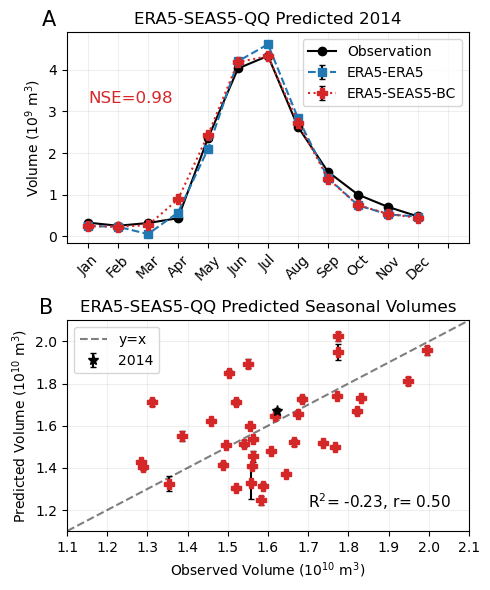

In [40]:
### plot

fig = plt.figure(figsize=(5,6))
# plot monthly volumes
plt.subplot(211)
plt.plot(hybridQQ12_run32[:,0]/(10**9), 'ko-', label='Observation')
plt.errorbar(np.arange(0,12,1), monthly12_run32[:,1]/(10**9), yerr=monthly12_run32[:,2]/(10**9), fmt='s--',
             color='tab:blue', ecolor='black', capsize=2, label='ERA5-ERA5')
plt.errorbar(np.arange(0,12,1), hybridQQ12_run32[:,1]/(10**9), yerr=hybridQQ12_run32[:,2]/(10**9), fmt='P:',
             color='tab:red', ecolor='black', capsize=2, markersize=7, label='ERA5-SEAS5-BC')
plt.text(0, 3.2, 'NSE='+str(round(hybridQQ12_run32_NSE,2)), color='tab:red', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], month_labels, rotation=45)
plt.ylabel(r'Volume ($\mathdefault{10^9}$ $\mathdefault{m^3}$)')
plt.title('ERA5-SEAS5-QQ Predicted 2014')
plt.legend(loc='upper right')
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-1.55,5.05, 'A', fontsize=15)
plt.xlim(-0.7,12.7)
plt.ylim(-0.16,4.9)
# plot seasonal volumes
plt.subplot(212)
plt.plot(y_equals_x, y_equals_x, 'k--', alpha=0.5, label='y=x')
plt.errorbar(hybridQQ12_vols[:32,1]/(10**10), hybridQQ12_vols[:32,2]/(10**10), yerr=hybridQQ12_vols[:32,3]/(10**10), fmt='P', color='tab:red',
             ecolor='black', capsize=2, markersize=7)
plt.errorbar(hybridQQ12_vols[33:,1]/(10**10), hybridQQ12_vols[33:,2]/(10**10), yerr=hybridQQ12_vols[33:,3]/(10**10), fmt='P', color='tab:red',
             ecolor='black', capsize=2, markersize=7)
plt.errorbar(hybridQQ12_vols[32,1]/(10**10), hybridQQ12_vols[32,2]/(10**10), yerr=hybridQQ12_vols[32,3]/(10**10), fmt='*', color='black',
             ecolor='black', capsize=2, markersize=8, label='2014')
plt.text(1.7, 1.21, r'$\mathdefault{R}^2$= '+str(round(hybridQQ12_vols_R2,2))+', r= '+str(round(hybridQQ12_vols_r,2))+'0', fontsize=11)
plt.xlabel(r'Observed Volume ($\mathregular{10^{10}}$ $\mathregular{m^3}$)')
plt.xticks([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1], [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1])
plt.ylabel(r'Predicted Volume ($\mathdefault{10^{10}}$ $\mathdefault{m^3}$)')
plt.title('ERA5-SEAS5-QQ Predicted Seasonal Volumes')
plt.text(1.03, 2.13, 'B', fontsize=15)
plt.xlim(1.1, 2.1)
plt.ylim(1.1, 2.1)
plt.legend(loc='upper left')
plt.grid(which='major', axis='both', alpha=0.2)
plt.tight_layout()
plt.show()
#plt.savefig('Fig11.pdf')

#### Figure 12

In [30]:
### load data

# volumes - 12-month
filename13 = 'Data_for_figures/Singlebasin_LSTM6_L1O_Set1_trainECMWF_volumes.csv'
trainECMWF12_vols = pd.read_csv(filename13, header=0)
trainECMWF12_vols = np.array(trainECMWF12_vols)
trainECMWF12_vols_R2 = R2_func(trainECMWF12_vols[:,1], trainECMWF12_vols[:,2])
trainECMWF12_vols_r, trainECMWF12_vols_p = pearsonr(trainECMWF12_vols[:,1], trainECMWF12_vols[:,2])

# streamflow - 12-month
filename14 = 'Data_for_figures/Singlebasin_LSTM6_L1O_run32_trainECMWF_output_unnorm.csv'
trainECMWF12_run32 = pd.read_csv(filename14, header=0)
trainECMWF12_run32 = np.array(trainECMWF12_run32)
trainECMWF12_run32_NSE = NSE_func(trainECMWF12_run32[:,0], trainECMWF12_run32[:,1])

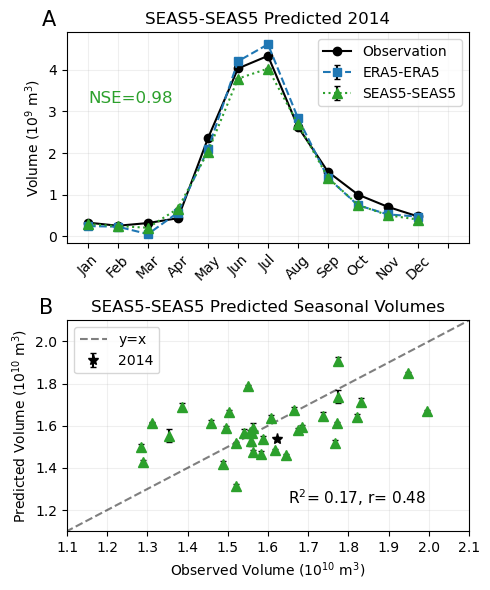

In [41]:
### plot

# month x-axis labels and indices
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '']
y_equals_x = np.arange(1.0, 2.4, 0.1)

# plot
fig = plt.figure(figsize=(5,6))
# plot monthly volumes
plt.subplot(211)
plt.plot(trainECMWF12_run32[:,0]/(10**9), 'ko-', label='Observation')
plt.errorbar(np.arange(0,12,1), monthly12_run32[:,1]/(10**9), yerr=monthly12_run32[:,2]/(10**9), fmt='s--',
             color='tab:blue', ecolor='black', capsize=2, label='ERA5-ERA5')
plt.errorbar(np.arange(0,12,1), trainECMWF12_run32[:,1]/(10**9), yerr=trainECMWF12_run32[:,2]/(10**9), fmt='^:',
             color='tab:green', ecolor='black', capsize=2, markersize=7, label='SEAS5-SEAS5')
plt.text(0, 3.2, 'NSE='+str(round(trainECMWF12_run32_NSE,2)), color='tab:green', fontsize=12)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], month_labels, rotation=45)
plt.ylabel(r'Volume ($\mathdefault{10^9}$ $\mathdefault{m^3}$)')
plt.title('SEAS5-SEAS5 Predicted 2014')
plt.legend(loc='upper right')
plt.grid(which='major', axis='both', alpha=0.2)
plt.text(-1.55,5.05, 'A', fontsize=15)
plt.xlim(-0.7,12.7)
plt.ylim(-0.16,4.9)
# plot seasonal volumes
plt.subplot(212)
plt.plot(y_equals_x, y_equals_x, 'k--', alpha=0.5, label='y=x')
plt.errorbar(trainECMWF12_vols[:32,1]/(10**10), trainECMWF12_vols[:32,2]/(10**10), yerr=trainECMWF12_vols[:32,3]/(10**10), fmt='^', color='tab:green',
             ecolor='black', capsize=2, markersize=7)
plt.errorbar(trainECMWF12_vols[33:,1]/(10**10), trainECMWF12_vols[33:,2]/(10**10), yerr=trainECMWF12_vols[33:,3]/(10**10), fmt='^', color='tab:green',
             ecolor='black', capsize=2, markersize=7)
plt.errorbar(trainECMWF12_vols[32,1]/(10**10), trainECMWF12_vols[32,2]/(10**10), yerr=trainECMWF12_vols[32,3]/(10**10), fmt='*', color='black',
             ecolor='black', capsize=2, markersize=8, label='2014')
plt.text(1.65, 1.23, r'$\mathdefault{R}^2$= '+str(round(trainECMWF12_vols_R2,2))+', r= '+str(round(trainECMWF12_vols_r,2)), fontsize=11)
plt.xlabel(r'Observed Volume ($\mathdefault{10^{10}}$ $\mathdefault{m^3}$)')
plt.xticks([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1], [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1])
plt.ylabel(r'Predicted Volume ($\mathdefault{10^{10}}$ $\mathdefault{m^3}$)')
plt.title('SEAS5-SEAS5 Predicted Seasonal Volumes')
plt.text(1.03, 2.13, 'B', fontsize=15)
plt.xlim(1.1, 2.1)
plt.ylim(1.1, 2.1)
plt.legend(loc='upper left')
plt.grid(which='major', axis='both', alpha=0.2)
plt.tight_layout()
plt.show()
#plt.savefig('Fig12.pdf')